# Day 3 作业--Pixel2Pixel：人像卡通化

经过今天的学习，相信大家对图像翻译、风格迁移有了一定的了解啦，是不是也想自己动手来实现下呢？

那么，为了满足大家动手实践的愿望，同时为了巩固大家学到的知识，我们Day 3的作业便是带大家完成一遍课程讲解过的应用--**Pixel2Pixel：人像卡通化**

在本次作业中，大家需要做的是：**补齐代码，跑通训练，提交一张卡通化的成品图，动手完成自己的第一个人像卡通化的应用~**

![](https://ai-studio-static-online.cdn.bcebos.com/6e3af14bf9f847ab92215753fb3b8f61a66186b538f44da78ca56627c35717b8)

## 准备工作：引入依赖 & 数据准备

In [2]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='1000px' width='1000px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [3]:
# 解压数据
!unzip -q data/data79149/cartoon_A2B.zip -d data/

### 数据可视化

训练集数据量: 1361
测试集数据量: 100


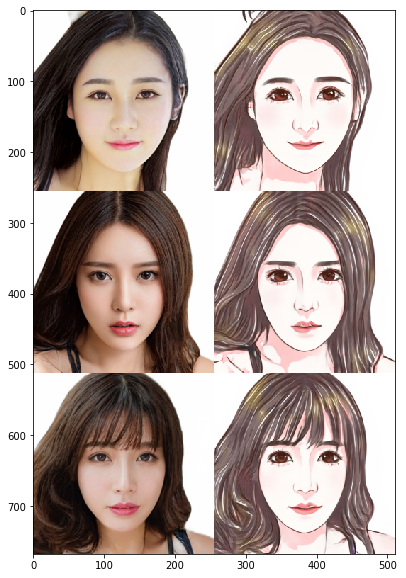

In [5]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):
    imgs.append(cv2.imread('data/cartoon_A2B/train/'+img_name))

img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

In [6]:
class PairedData(Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量

    def __getitem__(self, idx):
        img_A2B = cv2.imread(self.img_path_list[idx])     # 读取一组数据
        img_A2B = img_A2B.astype("float32") / 127.5 - 1   # 从0~255归一化至-1~1
        img_A2B = img_A2B.transpose(2, 0, 1)              # 维度变换HWC -> CHW
        img_A = img_A2B[:, :, :256]                       # 真人照
        img_B = img_A2B[:, :, 256:]                       # 卡通图
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]

In [7]:
paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

## 第一步：搭建生成器

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [16]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
            nn.LeakyReLU(0.2),                                                        # LeakyReLU, leaky=0.2
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False), # Conv2D
            nn.BatchNorm2D(out_dim)                                                   # BatchNorm2D
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            nn.ReLU(),                                                                          # ReLU
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),  # Conv2DTranspose
            nn.BatchNorm2D(out_dim)                                                             # nn.BatchNorm2D
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

## 第二步：鉴别器的搭建

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [17]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),  # Conv2D
            nn.BatchNorm2D(out_dim),                                                    # BatchNorm2D
            nn.LeakyReLU(0.2)                                                           # LeakyReLU, leaky=0.2
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [18]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()

In [19]:
out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)  # 应为[1, 3, 256, 256]

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)  # 应为[1, 1, 30, 30]

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 30, 30]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


In [20]:
# 超参数
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 100

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )

In [21]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):
        real_A, real_B = data
        
        optimizerD.clear_grad()
        # D([real_A, real_B])
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])
        fake_B = generator(real_A).detach()
        fake_AB = paddle.concat((real_A, fake_B), axis=1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_fake_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A, fake_B), axis=1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(g_fake_predict))
        g_l1_loss = l1_loss(fake_B, real_B)
        g_loss = g_bce_loss + g_l1_loss * 100.
        
        # train G
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()

  0%|          | 0/170 [00:00<?, ?it/s]/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
  1%|          | 1/170 [00:00<00:27,  6.25it/s]

Epoch [1/100] Loss D: [0.45912892], Loss G: [13.408944]


  1%|          | 1/170 [00:00<00:25,  6.75it/s]

Epoch [2/100] Loss D: [0.5784323], Loss G: [12.528577]


  1%|          | 1/170 [00:00<00:25,  6.63it/s]

Epoch [3/100] Loss D: [0.46621078], Loss G: [12.318357]


  1%|          | 1/170 [00:00<00:24,  6.80it/s]

Epoch [4/100] Loss D: [0.5969579], Loss G: [11.182263]


  1%|          | 1/170 [00:00<00:26,  6.35it/s]

Epoch [5/100] Loss D: [0.55742383], Loss G: [10.966151]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [6/100] Loss D: [0.56520975], Loss G: [10.4353]


  1%|          | 1/170 [00:00<00:24,  6.84it/s]

Epoch [7/100] Loss D: [0.5940731], Loss G: [10.375614]


  1%|          | 1/170 [00:00<00:24,  6.84it/s]

Epoch [8/100] Loss D: [0.556549], Loss G: [10.444305]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch [9/100] Loss D: [0.5822928], Loss G: [9.918542]


  1%|          | 2/170 [00:00<00:24,  6.96it/s]100%|██████████| 170/170 [00:23<00:00,  7.30it/s]


Epoch [10/100] Loss D: [0.621264], Loss G: [9.885607]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch [11/100] Loss D: [0.63898265], Loss G: [9.688204]


  1%|          | 1/170 [00:00<00:26,  6.48it/s]

Epoch [12/100] Loss D: [0.69389427], Loss G: [9.521579]


  1%|          | 1/170 [00:00<00:24,  6.83it/s]

Epoch [13/100] Loss D: [0.6430744], Loss G: [9.187639]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch [14/100] Loss D: [0.6277409], Loss G: [9.066152]


  1%|          | 1/170 [00:00<00:25,  6.71it/s]

Epoch [15/100] Loss D: [0.6134841], Loss G: [8.085786]


  1%|          | 1/170 [00:00<00:23,  7.12it/s]

Epoch [16/100] Loss D: [0.58496964], Loss G: [8.578151]


  1%|          | 1/170 [00:00<00:24,  6.89it/s]

Epoch [17/100] Loss D: [0.53092253], Loss G: [8.318056]


  1%|          | 1/170 [00:00<00:26,  6.27it/s]

Epoch [18/100] Loss D: [0.7253914], Loss G: [8.716479]


  1%|          | 1/170 [00:00<00:25,  6.53it/s]

Epoch [19/100] Loss D: [0.57252175], Loss G: [7.59795]


100%|██████████| 170/170 [00:23<00:00,  7.34it/s]


Epoch [20/100] Loss D: [0.6109669], Loss G: [8.147961]


  1%|          | 1/170 [00:00<00:25,  6.51it/s]

Epoch [21/100] Loss D: [0.6536195], Loss G: [7.9027042]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch [22/100] Loss D: [0.67254233], Loss G: [7.533741]


  1%|          | 1/170 [00:00<00:24,  6.86it/s]

Epoch [23/100] Loss D: [0.67232865], Loss G: [8.657278]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch [24/100] Loss D: [0.60366553], Loss G: [7.0110464]


  1%|          | 1/170 [00:00<00:28,  5.89it/s]

Epoch [25/100] Loss D: [0.6264245], Loss G: [7.4313006]


  1%|          | 1/170 [00:00<00:25,  6.61it/s]

Epoch [26/100] Loss D: [0.6304808], Loss G: [6.703834]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch [27/100] Loss D: [0.624383], Loss G: [6.145959]


  1%|          | 1/170 [00:00<00:32,  5.23it/s]

Epoch [28/100] Loss D: [0.63618827], Loss G: [6.7229843]


  1%|          | 1/170 [00:00<00:25,  6.70it/s]

Epoch [29/100] Loss D: [0.62496406], Loss G: [6.7204866]


100%|██████████| 170/170 [00:23<00:00,  7.35it/s]


Epoch [30/100] Loss D: [0.6300109], Loss G: [6.5725718]


  1%|          | 1/170 [00:00<00:26,  6.42it/s]

Epoch [31/100] Loss D: [0.73086095], Loss G: [7.3550606]


  1%|          | 1/170 [00:00<00:24,  6.89it/s]

Epoch [32/100] Loss D: [0.6281228], Loss G: [6.467258]


  1%|          | 1/170 [00:00<00:25,  6.62it/s]

Epoch [33/100] Loss D: [0.6464799], Loss G: [6.27199]


  1%|          | 1/170 [00:00<00:26,  6.39it/s]

Epoch [34/100] Loss D: [0.6528895], Loss G: [6.3114944]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch [35/100] Loss D: [0.6263275], Loss G: [6.447165]


  1%|          | 1/170 [00:00<00:26,  6.48it/s]

Epoch [36/100] Loss D: [0.7075922], Loss G: [6.309616]


  1%|          | 1/170 [00:00<00:24,  6.78it/s]

Epoch [37/100] Loss D: [0.68071055], Loss G: [6.136921]


  1%|          | 1/170 [00:00<00:24,  6.81it/s]

Epoch [38/100] Loss D: [0.6303847], Loss G: [5.752825]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch [39/100] Loss D: [0.63670206], Loss G: [5.6684027]


  1%|          | 2/170 [00:00<00:23,  7.09it/s]100%|██████████| 170/170 [00:23<00:00,  7.18it/s]


Epoch [40/100] Loss D: [0.65063643], Loss G: [5.8713903]


  1%|          | 1/170 [00:00<00:26,  6.47it/s]

Epoch [41/100] Loss D: [0.7121489], Loss G: [5.7237253]


  1%|          | 1/170 [00:00<00:25,  6.52it/s]

Epoch [42/100] Loss D: [0.6331829], Loss G: [5.8360023]


  1%|          | 1/170 [00:00<00:28,  5.91it/s]

Epoch [43/100] Loss D: [0.63825905], Loss G: [5.2664046]


  1%|          | 1/170 [00:00<00:29,  5.77it/s]

Epoch [44/100] Loss D: [0.6169989], Loss G: [5.894608]


  1%|          | 1/170 [00:00<00:25,  6.56it/s]

Epoch [45/100] Loss D: [0.6520585], Loss G: [5.601864]


  1%|          | 1/170 [00:00<00:26,  6.45it/s]

Epoch [46/100] Loss D: [0.6473676], Loss G: [5.224633]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch [47/100] Loss D: [0.67689764], Loss G: [5.3380156]


  1%|          | 1/170 [00:00<00:27,  6.11it/s]

Epoch [48/100] Loss D: [0.6391379], Loss G: [5.273557]


  1%|          | 1/170 [00:00<00:27,  6.05it/s]

Epoch [49/100] Loss D: [0.639946], Loss G: [5.043042]


  1%|          | 2/170 [00:00<00:26,  6.40it/s]100%|██████████| 170/170 [00:23<00:00,  7.25it/s]


Epoch [50/100] Loss D: [0.7839357], Loss G: [4.9698615]


  1%|          | 1/170 [00:00<00:24,  6.86it/s]

Epoch [51/100] Loss D: [0.6349263], Loss G: [5.2692194]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch [52/100] Loss D: [0.64620835], Loss G: [5.194868]


  1%|          | 1/170 [00:00<00:26,  6.31it/s]

Epoch [53/100] Loss D: [0.6549575], Loss G: [5.272918]


  1%|          | 1/170 [00:00<00:24,  6.85it/s]

Epoch [54/100] Loss D: [0.6284356], Loss G: [5.041271]


  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch [55/100] Loss D: [0.6535957], Loss G: [4.888611]


  1%|          | 1/170 [00:00<00:29,  5.70it/s]

Epoch [56/100] Loss D: [0.65527546], Loss G: [5.191921]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch [57/100] Loss D: [0.62622225], Loss G: [4.7246532]


  1%|          | 1/170 [00:00<00:28,  5.99it/s]

Epoch [58/100] Loss D: [0.64133096], Loss G: [5.1963267]


  1%|          | 1/170 [00:00<00:25,  6.54it/s]

Epoch [59/100] Loss D: [0.66624194], Loss G: [4.960585]


  1%|          | 2/170 [00:00<00:25,  6.54it/s]100%|██████████| 170/170 [00:23<00:00,  7.15it/s]


Epoch [60/100] Loss D: [0.64714396], Loss G: [4.8644648]


  1%|          | 1/170 [00:00<00:25,  6.60it/s]

Epoch [61/100] Loss D: [0.6340579], Loss G: [4.6878715]


  1%|          | 1/170 [00:00<00:26,  6.28it/s]

Epoch [62/100] Loss D: [0.62646174], Loss G: [4.870828]


  1%|          | 1/170 [00:00<00:27,  6.21it/s]

Epoch [63/100] Loss D: [0.64069355], Loss G: [4.735431]


  1%|          | 1/170 [00:00<00:24,  6.84it/s]

Epoch [64/100] Loss D: [0.64017934], Loss G: [4.700816]


  1%|          | 1/170 [00:00<00:24,  6.86it/s]

Epoch [65/100] Loss D: [0.6240092], Loss G: [4.99401]


  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch [66/100] Loss D: [0.63689834], Loss G: [4.731893]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch [67/100] Loss D: [0.64102596], Loss G: [4.501354]


  1%|          | 1/170 [00:00<00:28,  5.92it/s]

Epoch [68/100] Loss D: [0.6629565], Loss G: [4.9390664]


  1%|          | 1/170 [00:00<00:24,  6.89it/s]

Epoch [69/100] Loss D: [0.61756665], Loss G: [4.6330447]


  1%|          | 2/170 [00:00<00:23,  7.01it/s]100%|██████████| 170/170 [00:23<00:00,  7.23it/s]


Epoch [70/100] Loss D: [0.65200686], Loss G: [4.7973604]


  1%|          | 1/170 [00:00<00:24,  6.78it/s]

Epoch [71/100] Loss D: [0.67305905], Loss G: [4.654288]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch [72/100] Loss D: [0.63888067], Loss G: [4.8020005]


  1%|          | 1/170 [00:00<00:26,  6.27it/s]

Epoch [73/100] Loss D: [0.67541206], Loss G: [4.687545]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch [74/100] Loss D: [0.6575929], Loss G: [4.61067]


  1%|          | 1/170 [00:00<00:25,  6.65it/s]

Epoch [75/100] Loss D: [0.6542257], Loss G: [4.164081]


  1%|          | 1/170 [00:00<00:23,  7.09it/s]

Epoch [76/100] Loss D: [0.6774094], Loss G: [4.151257]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [77/100] Loss D: [0.67947114], Loss G: [4.5224166]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [78/100] Loss D: [0.6408311], Loss G: [4.4589586]


  1%|          | 1/170 [00:00<00:25,  6.65it/s]

Epoch [79/100] Loss D: [0.66603684], Loss G: [4.933146]


  1%|          | 2/170 [00:00<00:24,  6.87it/s]100%|██████████| 170/170 [00:23<00:00,  7.35it/s]


Epoch [80/100] Loss D: [0.66926396], Loss G: [4.351647]


  1%|          | 1/170 [00:00<00:28,  5.96it/s]

Epoch [81/100] Loss D: [0.6816841], Loss G: [4.7642517]


  1%|          | 1/170 [00:00<00:28,  5.91it/s]

Epoch [82/100] Loss D: [0.649845], Loss G: [4.392674]


  1%|          | 1/170 [00:00<00:24,  6.82it/s]

Epoch [83/100] Loss D: [0.66413057], Loss G: [4.2685304]


  1%|          | 1/170 [00:00<00:24,  6.80it/s]

Epoch [84/100] Loss D: [0.6456108], Loss G: [4.4230046]


  1%|          | 1/170 [00:00<00:23,  7.12it/s]

Epoch [85/100] Loss D: [0.65293455], Loss G: [4.348132]


  1%|          | 1/170 [00:00<00:27,  6.19it/s]

Epoch [86/100] Loss D: [0.68164295], Loss G: [4.3992352]


  1%|          | 1/170 [00:00<00:24,  6.83it/s]

Epoch [87/100] Loss D: [0.65441185], Loss G: [4.3864074]


  1%|          | 1/170 [00:00<00:25,  6.55it/s]

Epoch [88/100] Loss D: [0.6399721], Loss G: [4.337789]


  1%|          | 1/170 [00:00<00:25,  6.74it/s]

Epoch [89/100] Loss D: [0.62588924], Loss G: [4.4269104]


100%|██████████| 170/170 [00:23<00:00,  7.19it/s]


Epoch [90/100] Loss D: [0.65851563], Loss G: [4.2246466]


  1%|          | 1/170 [00:00<00:26,  6.46it/s]

Epoch [91/100] Loss D: [0.6550821], Loss G: [3.9132943]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch [92/100] Loss D: [0.65003246], Loss G: [4.161619]


  1%|          | 1/170 [00:00<00:28,  5.94it/s]

Epoch [93/100] Loss D: [0.64633745], Loss G: [4.0948586]


  1%|          | 1/170 [00:00<00:28,  5.90it/s]

Epoch [94/100] Loss D: [0.70065355], Loss G: [4.2262354]


  1%|          | 1/170 [00:00<00:28,  6.01it/s]

Epoch [95/100] Loss D: [0.67512405], Loss G: [4.690836]


  1%|          | 1/170 [00:00<00:27,  6.24it/s]

Epoch [96/100] Loss D: [0.66436917], Loss G: [4.601118]


  1%|          | 1/170 [00:00<00:27,  6.26it/s]

Epoch [97/100] Loss D: [0.65829635], Loss G: [4.243505]


  1%|          | 1/170 [00:00<00:24,  6.77it/s]

Epoch [98/100] Loss D: [0.73826927], Loss G: [4.508725]


  1%|          | 1/170 [00:00<00:26,  6.37it/s]

Epoch [99/100] Loss D: [0.6403869], Loss G: [4.1683493]


100%|██████████| 170/170 [00:23<00:00,  7.26it/s]


Epoch [100/100] Loss D: [0.6394289], Loss G: [4.1568]


## Epoch 100保存的结果展示

![](https://ai-studio-static-online.cdn.bcebos.com/c6919d59e1434b3e9702596057a13d4888a7861f17f94796a476aa77bfea0e45)


## 最后：用你补齐的代码试试卡通化的效果吧！

In [22]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: work/weights/epoch100.pdparams


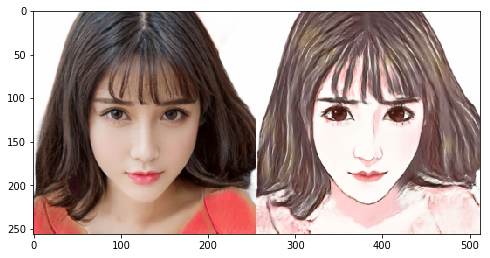

In [23]:
# 读取数据
test_names = os.listdir('data/cartoon_A2B/test')
img_name = np.random.choice(test_names)
img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)
img_A = img_A2B[:, :256]                                  # 真人照
img_B = img_A2B[:, 256:]                                  # 卡通图

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([img_A, g_output])[:,:,::-1]
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()

In [ ]:
zip 